# Reconstruction of volume from simulated data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *
from src.jaxops import *
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
from pyfftw.builders import irfft2

plt.rcParams["figure.figsize"]=8,8

### Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

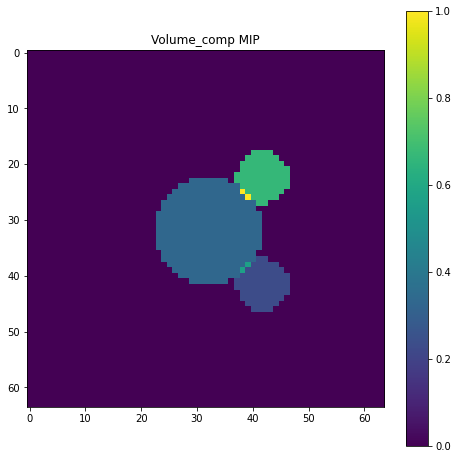

In [3]:
nx = 64
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])
pixel_size = dimensions[0]/shape[0]

# A volume with components
centres = np.array([[0,0,0], [3, 3, 0], [3, -3, 0]])
radii = np.array([3, 1.5, 1.5])
intensities = np.array([10,7,20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, x_grid = volume_fourier(jnp.fft.ifftshift(vol), pixel_size)

y_grid = x_grid
z_grid = x_grid

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

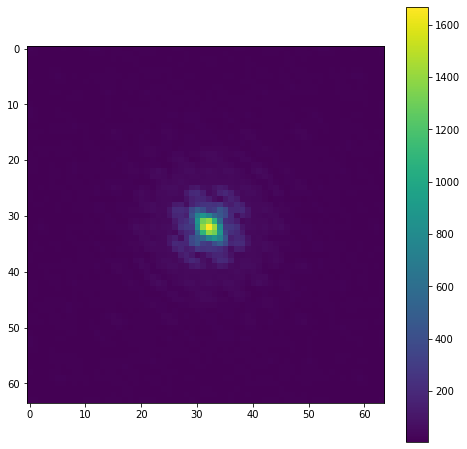

In [4]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

### Generate the data

CTF

In [5]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
_, p = next(dfiter)

#ctf_params = {'def1'  : p[star.Relion.DEFOCUSU], 
#              'def2'  : p[star.Relion.DEFOCUSV],
#              'angast': p[star.Relion.DEFOCUSANGLE], 
#              'phase' : p[star.Relion.PHASESHIFT],
#              'kv'    : p[star.Relion.VOLTAGE],
#              'ac'    : p[star.Relion.AC], 
#              'cs'    : p[star.Relion.CS], 
#              'bf'    : 0,
#              'lp'    : 2 * pixel_size}

ctf_params0 = np.array([p[star.Relion.DEFOCUSU],
                      p[star.Relion.DEFOCUSV],
                      p[star.Relion.DEFOCUSANGLE], 
                      p[star.Relion.PHASESHIFT],
                      p[star.Relion.VOLTAGE],
                      p[star.Relion.AC],
                      p[star.Relion.CS],
                      0,
                      2 * pixel_size])

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


Generate projections (in Fourier domain)

1.2642507553100586


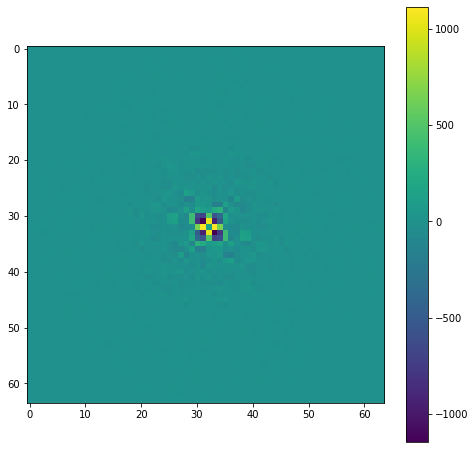

In [6]:
radius = 10
mask = create_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array = get_slice_funcs(project, x_grid, y_grid, z_grid, mask, "tri")

img0 = slice_func(vol_fourier, [0,0,0], [0,0], ctf_params0)

N = 1000

# Non uniformly distributed orientations (here, two clusters)
s = 0.1
#angles_true = jnp.array(np.random.rand(N,3))*jnp.pi*2
#angles_true = s*np.random.randn(int(N),3)
angles_true = np.concatenate([s*np.random.randn(int(N/2),3), s*np.random.randn(int(N/2),3)+np.pi], axis=0)
np.random.shuffle(angles_true)
angles_true = jnp.array(angles_true)


shifts_true = jnp.zeros([N,3])
ctf_params = jnp.array([ctf_params0] * N)
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true, shifts_true, ctf_params)

# Noise
#imgs += (np.random.randn(N, nx*nx) + 1j*np.random.randn(N, nx*nx)) * jnp.max(img0) /2

print(time.time()-start)

plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

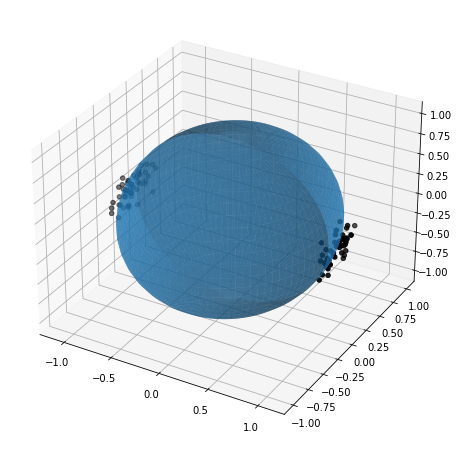

In [7]:
plot_angles(angles_true[:100])

### Crop images and volume:

In [8]:
from src.emfiles import crop_fourier_images, crop_fourier_volume

nx = 32
imgs = imgs.reshape(imgs.shape[0], 64, 64)
imgs, x_grid = crop_fourier_images(imgs, x_grid, nx)
imgs = imgs.reshape(imgs.shape[0], nx*nx)

vol_fourier, _ = crop_fourier_volume(vol_fourier, x_grid, nx)

y_grid = x_grid
z_grid = x_grid

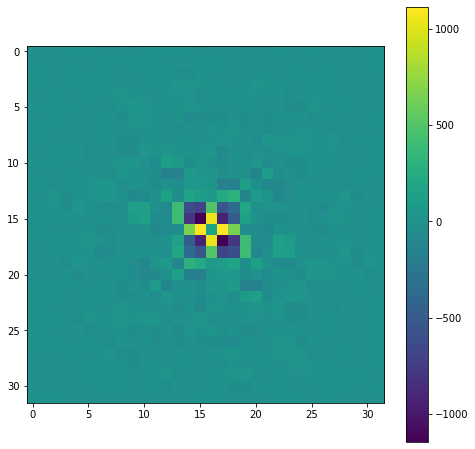

In [9]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

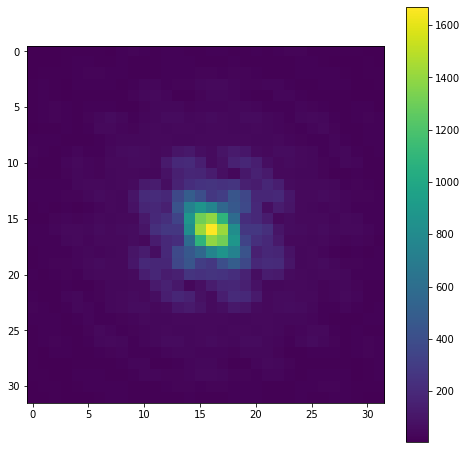

In [10]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

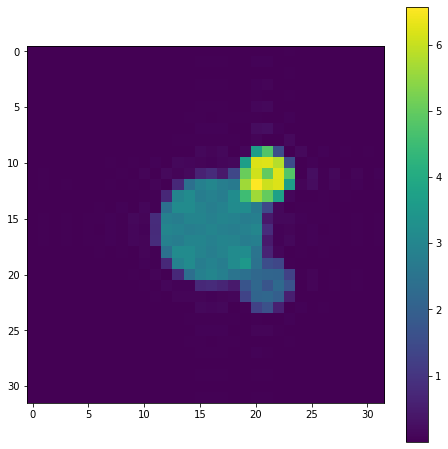

In [11]:
mip_z(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier)))); plt.colorbar()

### Loss functions for the new dimension

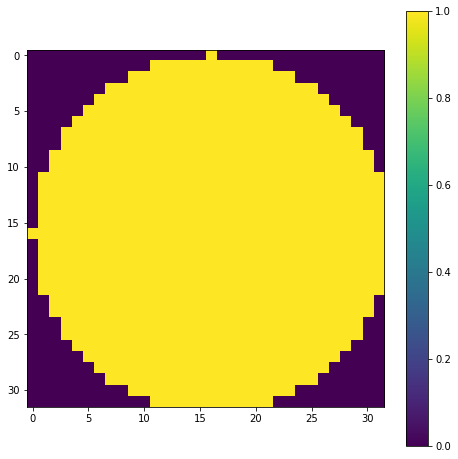

In [12]:
alpha = 0.001

radius = 0.8
mask = create_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array = get_slice_funcs(project, x_grid, y_grid, z_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [13]:
start = time.time()
ll = loss_func_batched(np.random.randn(nx,nx,nx), angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
print(time.time()-start)
print(ll.shape)

1.414496660232544
(20,)


Gradients with respect to volume pixels, over all (or a batch of) images

In [14]:
start = time.time()
ll = grad_loss_volume(np.random.randn(nx,nx,nx), angles_true[0],  shifts_true[0], ctf_params[0], imgs[0])
print(time.time()-start)
print(ll.shape)

1.2767970561981201
(32, 32, 32)


Doing the below with N large enough (e.g. 1000) makes it run out of memory (trying to allocate >200GB)

In [15]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(np.random.randn(nx,nx,nx), angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx])
print(time.time()-start)
print(ll.shape)

1.9812326431274414
(32, 32, 32)


## Optimization with respect to volume

### CG - applied to two halves of the data

In [16]:
from src.algorithm import conjugate_gradient, get_cg_vol_ops

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 50

N2 = jnp.floor(N/2).astype(jnp.int64)
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[:N2], shifts_true[:N2], ctf_params[:N2], imgs[:N2], v0.shape)

vcg1,_ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

Iter 0 ||r|| = 0.4374656376445139
Iter 1 ||r|| = 0.1717908883871161
Iter 2 ||r|| = 0.0886526897314692
Iter 3 ||r|| = 0.0746231750977304
Iter 4 ||r|| = 0.06598967034043476
Iter 5 ||r|| = 0.05728495815893656
Iter 6 ||r|| = 0.047791527452560094
Iter 7 ||r|| = 0.04575927237170324
Iter 8 ||r|| = 0.03679171887033085
Iter 9 ||r|| = 0.03240387354274694
Iter 10 ||r|| = 0.022884383862552385
Iter 11 ||r|| = 0.0200586030912824
Iter 12 ||r|| = 0.017620714615759887
Iter 13 ||r|| = 0.015716624648439804
Iter 14 ||r|| = 0.01488968346629573
Iter 15 ||r|| = 0.012772187385041973
Iter 16 ||r|| = 0.012634496965953161
Iter 17 ||r|| = 0.010798890555185467
Iter 18 ||r|| = 0.009822456785726186
Iter 19 ||r|| = 0.009679143253014213
Iter 20 ||r|| = 0.008940467520475295
Iter 21 ||r|| = 0.007764526072321309
Iter 22 ||r|| = 0.008294119992606694
Iter 23 ||r|| = 0.007310108878171172
Iter 24 ||r|| = 0.006482592770582476
Iter 25 ||r|| = 0.005843613653404806
Iter 26 ||r|| = 0.005383450564926882
Iter 27 ||r|| = 0.004600871

In [17]:
AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:], v0.shape)

vcg2, _ = conjugate_gradient(AA2, Ab2, v0, N_iter, verbose = True)

Iter 0 ||r|| = 0.44263911920232096
Iter 1 ||r|| = 0.17307205105881007
Iter 2 ||r|| = 0.087207176045462
Iter 3 ||r|| = 0.07116550174032286
Iter 4 ||r|| = 0.06323565269663906
Iter 5 ||r|| = 0.05713411680916758
Iter 6 ||r|| = 0.04699804376710782
Iter 7 ||r|| = 0.043960021656913595
Iter 8 ||r|| = 0.036396465765524216
Iter 9 ||r|| = 0.032282368971722195
Iter 10 ||r|| = 0.023682703291620023
Iter 11 ||r|| = 0.019264753311421072
Iter 12 ||r|| = 0.018135417835075454
Iter 13 ||r|| = 0.015679871579573307
Iter 14 ||r|| = 0.014947447960231878
Iter 15 ||r|| = 0.012971060868266604
Iter 16 ||r|| = 0.011782589947242322
Iter 17 ||r|| = 0.010833102351318733
Iter 18 ||r|| = 0.009339379938365464
Iter 19 ||r|| = 0.009223104238045458
Iter 20 ||r|| = 0.007629379139147802
Iter 21 ||r|| = 0.006671746730814556
Iter 22 ||r|| = 0.006693311502580813
Iter 23 ||r|| = 0.006439435732166261
Iter 24 ||r|| = 0.005853906607624595
Iter 25 ||r|| = 0.005741486552561327
Iter 26 ||r|| = 0.005191806990993489
Iter 27 ||r|| = 0.00

In [18]:
#print("Final loss function = ", loss_func_sum(vcg, angles_true, shifts_true, ctf_params, imgs))
print("Relative error = ", jnp.max(jnp.abs((vcg1 - vol_fourier)/jnp.max(vol_fourier))))
print("Absolute error = ", jnp.mean(jnp.abs((vcg1 - vol_fourier))))

Relative error =  0.9102548746703139
Absolute error =  22.23824597489659


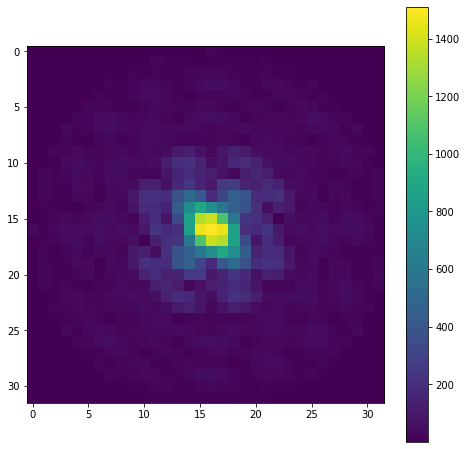

In [19]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1)))) ; plt.colorbar()

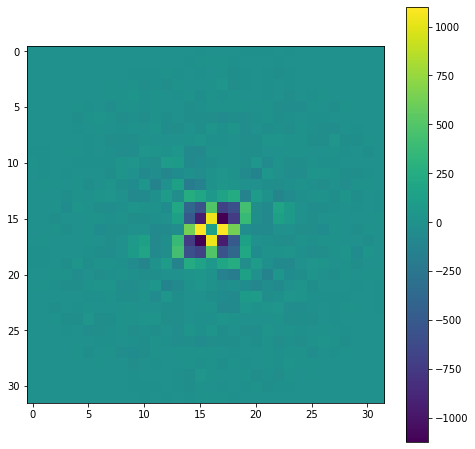

In [20]:
idx = 709

s0 = slice_func(vcg1, angles_true[idx], shifts_true[idx], ctf_params[idx])
plt.imshow(jnp.fft.fftshift(jnp.real(s0).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

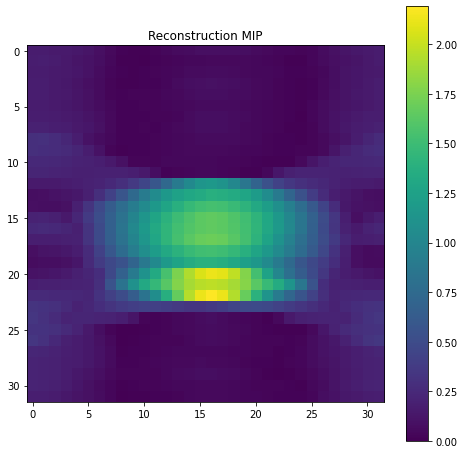

In [21]:
mip_x(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction MIP')

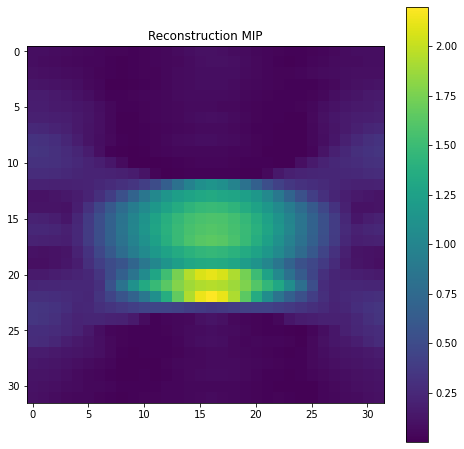

In [22]:
mip_x(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

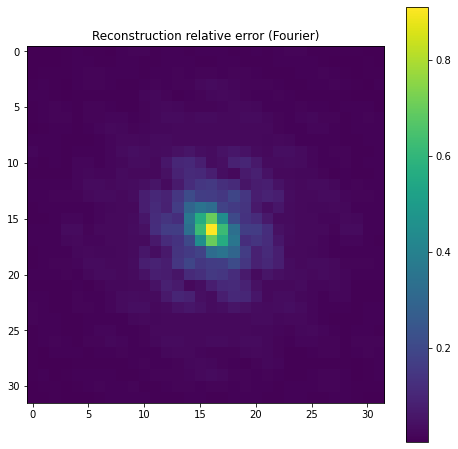

In [23]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

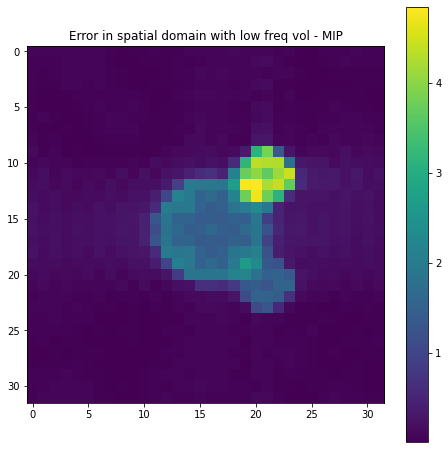

In [24]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier - vcg1)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

### FSC

In [25]:
res, fsc = calc_fsc(vcg1, vcg2, x_grid, dr = 0.05)

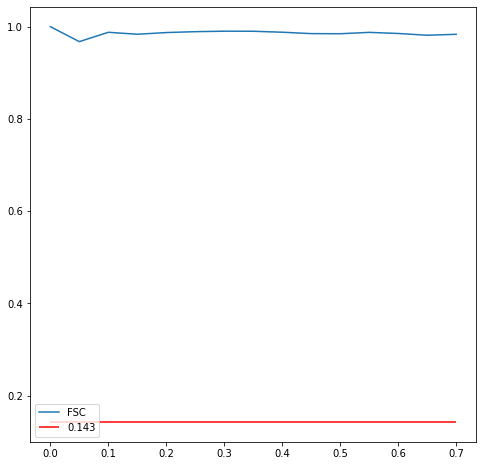

In [26]:
plt.plot(res, fsc)
plt.hlines(0.143, xmin=min(res), xmax=max(res), colors = ['r'])
plt.legend(['FSC', '0.143'])

In [27]:
res

DeviceArray([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45,
             0.5 , 0.55, 0.6 , 0.65, 0.7 ], dtype=float64)

### SGD

In [28]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
#v0 = vol_fourier + 0.1*v * mask
#alpha = 1000000 # this alpha works well for full 128 x 128 x 128 volume with mask
alpha = 10000000
batch_size = 2
N_iter = 1000 * 20 
#N_iter = 1000 

v = v0
for i in range(N_iter):
    
    idx = np.random.default_rng().choice(N, size=batch_size, replace = False)
    
    if jnp.mod(i,100) == 0:
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(v, angles_true[idx], imgs[idx]))))

    v = v - alpha * jnp.conj(grad_loss_volume_batched(v, angles_true[idx], imgs[idx]))
    
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

TypeError: loss_func_batched() missing 2 required positional arguments: 'ctf_params' and 'imgs'

In [ ]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

In [ ]:
loss_imgs = loss_func_batched(v, angles_true, imgs)
plt.plot(loss_imgs)

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift((v-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

In [ ]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift((v)))) ; plt.colorbar()

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - v*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

In [ ]:
mip_z(jnp.abs(vol-jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

In [ ]:
mip_z(jnp.abs(vol-jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier*mask)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

## Gradient descent with respect to angles

And the gradients of the above, with respect to angles, here for later,not really used right now:

In [ ]:
@jax.jit
def grad_loss_angles(v, angles, shifts, ctf_params, img):
    return jax.grad(loss_func, argnums = 1)(v, angles, shifts, ctf_params, img)

@jax.jit
def grad_loss_angles_batched(v, angles, shifts, ctf_params, imgs):
    return jax.vmap(grad_loss_angles, in_axes = (None, 0, 0, 0, 0))(v, angles, shifts, ctf_params, imgs)

In [ ]:
start = time.time()
dl = grad_loss_angles(vol_fourier, angles_true[0], shifts_true[0], ctf_params[0], imgs[0])
print(time.time()-start)
print(dl.shape)

In [ ]:
#start = time.time()
#dl = grad_loss_angles_batched(vol_fourier, angles_true, imgs)
#print(time.time()-start)
#print(dl.shape)

In [ ]:
#beta = 0.00000001
#a = jnp.array(np.random.rand(N, 3)*np.pi*2)
#a = jnp.mod(a, 2*jnp.pi)
##a = angles_true + 0.01*a
#N_iter = 1
#
#for i in range(N_iter):
#        
#    if jnp.mod(i,100) == 0:
#    #print(i)
#        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(vol_fourier, a, shifts_true, ctf_params, imgs))))
#        
#    a = a - beta * jnp.conj(grad_loss_angles_batched(vol_fourier, a, shifts_true, ctf_params, imgs))
#    
#a = jnp.mod(a, 2*jnp.pi)


    
#max_err = jnp.mean(jnp.abs(a - angles_true))
#print("mean(a-a_true) = " + str(max_err))

In [ ]:
#max_err = jnp.max(jnp.abs(a - angles_true))
#print("max(a-a_true) = " + str(max_err))